In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

%matplotlib inline
pd.set_option("max_columns", 999)

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services
In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [178]:
dfa = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')

Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


In [179]:
dfc = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

In [6]:
dfa.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [18]:
dfa.shape

(891221, 366)

In [12]:
dfc.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [649]:
dfc.shape

(191652, 369)

In [22]:
dfc['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [21]:
dfc['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [23]:
dfc['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [24]:
dfc['ANREDE_KZ'].value_counts() # more male than female

1    119508
2     72144
Name: ANREDE_KZ, dtype: int64

In [28]:
dfc['CAMEO_DEUG_2015'].value_counts()

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

In [5]:
dfa['CAMEO_DEUG_2015'] = pd.to_numeric(dfa['CAMEO_DEUG_2015'].replace('X', 0), downcast='integer').fillna(0).astype('int')
dfc['CAMEO_DEUG_2015'] = pd.to_numeric(dfc['CAMEO_DEUG_2015'].replace('X', 0), downcast='integer').fillna(0).astype('int')

## Exploratory data analysis
Before starting to cluster the data, we explore the difference between the general population and the customer population. Below we report some of the characteristics that seem more important for a characterization of the customers.

In [116]:
def plot_feature_difference(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,4))
    dfa[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='population')
    dfc[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers',color='r')

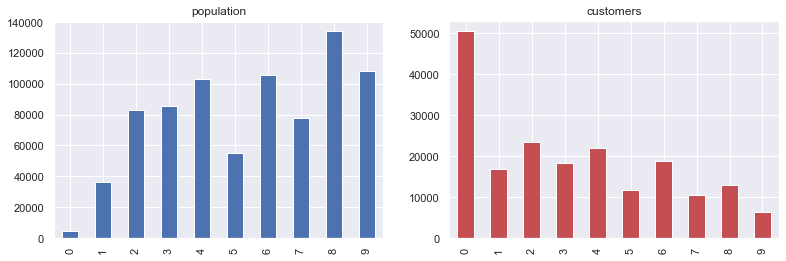

In [117]:
plot_feature_difference('CAMEO_DEUG_2015')

CAMEO_DEUG_2015  
1	upper class  
2	upper middleclass  
3	established middleclasse  
4	consumption-oriented middleclass   
5	active middleclass  
6	low-consumption middleclass  
7	lower middleclass  
8	working class  
9	urban working class  

In [89]:
(dfa['CAMEO_DEUG_2015'].value_counts().loc[8] + dfa['CAMEO_DEUG_2015'].value_counts().loc[9]) / (dfa['CAMEO_DEUG_2015'].count() - dfa['CAMEO_DEUG_2015'].value_counts().loc[0])

0.30638653615686434

In [90]:
(dfc['CAMEO_DEUG_2015'].value_counts().loc[8] + dfc['CAMEO_DEUG_2015'].value_counts().loc[9]) / (dfc['CAMEO_DEUG_2015'].count() - dfc['CAMEO_DEUG_2015'].value_counts().loc[0])

0.13778366808884604

In [94]:
(dfa['CAMEO_DEUG_2015'].value_counts().loc[1] + dfa['CAMEO_DEUG_2015'].value_counts().loc[2]) / (dfa['CAMEO_DEUG_2015'].count() - dfa['CAMEO_DEUG_2015'].value_counts().loc[0])

0.15083681770595894

In [93]:
(dfc['CAMEO_DEUG_2015'].value_counts().loc[1] + dfc['CAMEO_DEUG_2015'].value_counts().loc[2]) / (dfc['CAMEO_DEUG_2015'].count() - dfc['CAMEO_DEUG_2015'].value_counts().loc[0])

0.285347772470198

It is possible to see the difference in the percentage of working class, much higher for the general population (31%) that for the customers (14%). Instead the upper class and upper middleclass account for just 15% of the general population but almost twice as much in the customers (29%).

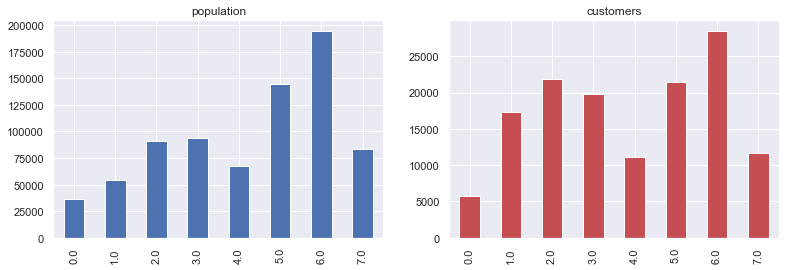

In [118]:
plot_feature_difference('REGIOTYP')

REGIOTYP	neighbourhood   
-1, 0	unknown  
		1	upper class  
		2	conservatives  
		3	upper middle class  
		4	middle class  
		5	lower middle class  
		6	traditional workers  
		7	marginal groups

It is possible to see how the most represented age bracket in the general population is that one between 46-60, while among the cusomers the over 60 are the most repreented.

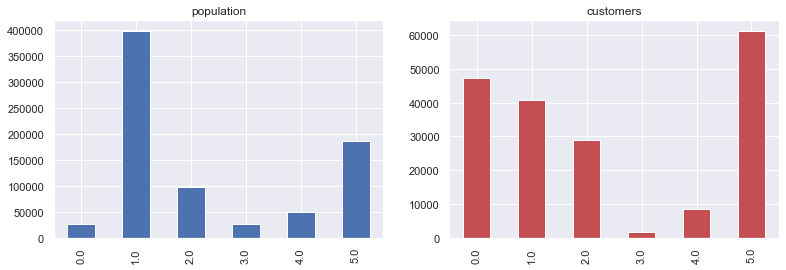

In [120]:
plot_feature_difference('LP_FAMILIE_GROB')

1 single   
2 couple  
3 single parent  
4 family  
5 multiperson household

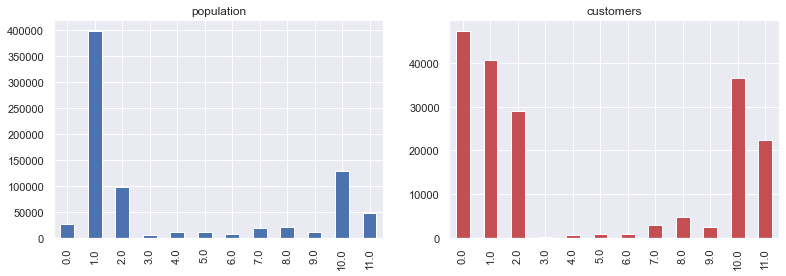

In [121]:
plot_feature_difference('LP_FAMILIE_FEIN')

LP_FAMILIE_FEIN  
1	single  
2	couple  
3	young single parent   
4	single parent with teenager  
5	single parent with child of full age  
6	young family   
7	family with teenager   
8	family with child of full age  
9	shared flat  
10	two-generational household  
11	multi-generational household  

It is surprising the data that such large proportion of the general population is sigle. However the customers in proporetion are many more couples and two/multi-generation household.

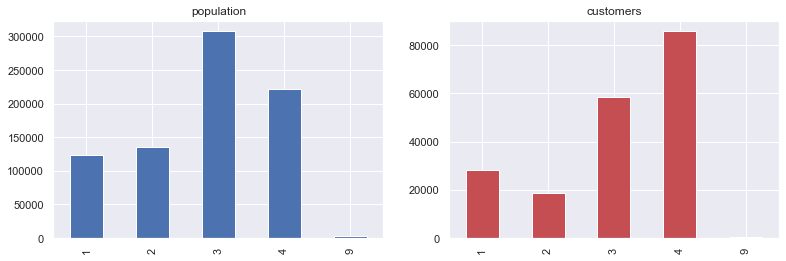

In [122]:
plot_feature_difference('ALTERSKATEGORIE_GROB')

ALTERSKATEGORIE_GROB	
age classification through prename analysis  
-1, 0	unknown  
		1	< 30 years  
		2	30 - 45 years  
		3	46 - 60 years  
		4	> 60 years  
		9	uniformly distributed  

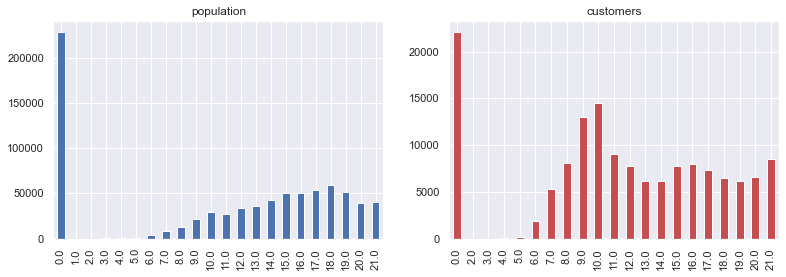

In [123]:
plot_feature_difference('ALTER_HH')

ALTER_HH  
0	unknown / no main age detectable  
1	01.01.1895 bis 31.12.1899  
2	01.01.1900 bis 31.12.1904  
3	01.01.1905 bis 31.12.1909  
4	01.01.1910 bis 31.12.1914  
5	01.01.1915 bis 31.12.1919  
6	01.01.1920 bis 31.12.1924  
7	01.01.1925 bis 31.12.1929  
8	01.01.1930 bis 31.12.1934  
9	01.01.1935 bis 31.12.1939  
10	01.01.1940 bis 31.12.1944  
11	01.01.1945 bis 31.12.1949  
12	01.01.1950 bis 31.12.1954  
13	01.01.1955 bis 31.12.1959  
14	01.01.1960 bis 31.12.1964  
15	01.01.1965 bis 31.12.1969  
16	01.01.1970 bis 31.12.1974  
17	01.01.1975 bis 31.12.1979  
18	01.01.1980 bis 31.12.1984  
19	01.01.1985 bis 31.12.1989  
20	01.01.1990 bis 31.12.1994  
21	01.01.1995 bis 31.12.1999  

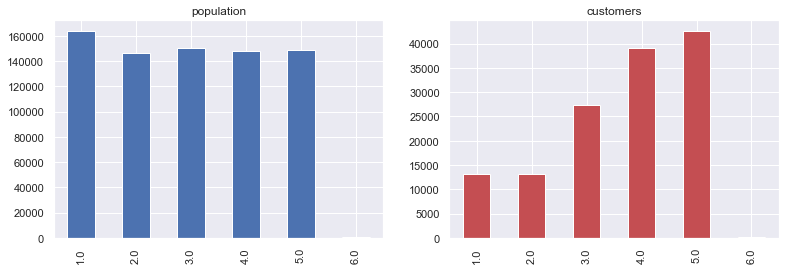

In [124]:
plot_feature_difference('MOBI_REGIO')

MOBI_REGIO	moving patterns  
1	very high mobility  
		2	high mobility  
		3	middle mobility  
		4	low mobility  
		5	very low mobility  
		6	none

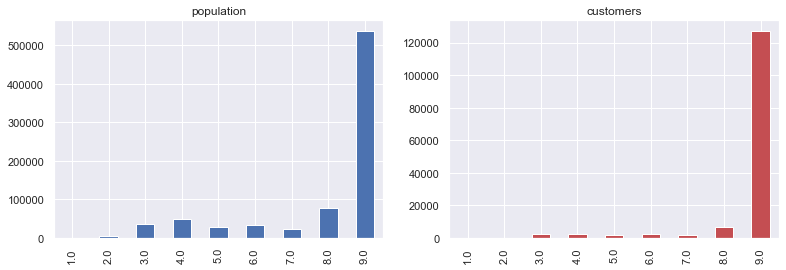

In [125]:
plot_feature_difference('WOHNDAUER_2008')

WOHNDAUER_2008	length of residence  
-1, 0	unknown  
		1	length of residence below 1 year  
		2	length of residence 1-2 years  
		3	length of residence 2-3 years  
		4	length of residence 3-4 years  
		5	length of residence 4-5 years  
		6	length of residence 5-6 years  
		7	length of residence 6-7 years  
		8	length of residence 7-10 years  
		9	length of residence more than 10 years  

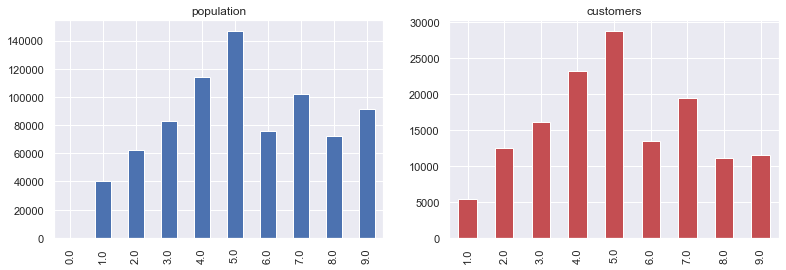

In [126]:
plot_feature_difference('ORTSGR_KLS9')

ORTSGR_KLS9	size of the community- classified number of inhabitants	

-1	unknown
	'1	<= 2.000 inhabitants  
		2	2.001 to 5.000 inhabitants  
		3	5.001 to 10.000 inhabitants  
		4	10.001 to 20.000 inhabitants  
		5	20.001 to 50.000 inhabitants  
		6	50.001 to 100.000 inhabitants  
		7	100.001 to 300.000 inhabitants  
		8	300.001 to 700.000 inhabitants  
		9	> 700.000  inhabitants

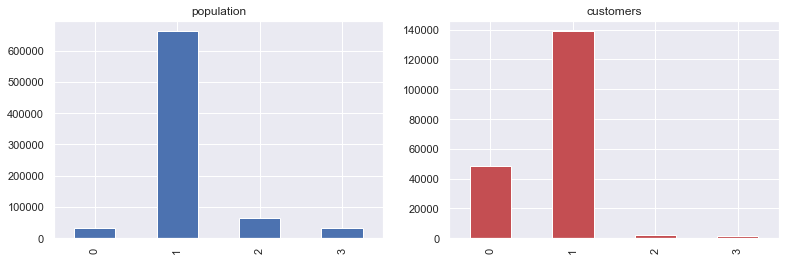

In [127]:
plot_feature_difference('NATIONALITAET_KZ')

NATIONALITAET_KZ	nationaltity (scored by prename analysis)	  
-1, 0	unknown  
		1	sounding german  
		2	sounding foreign  
		3	assimilated names

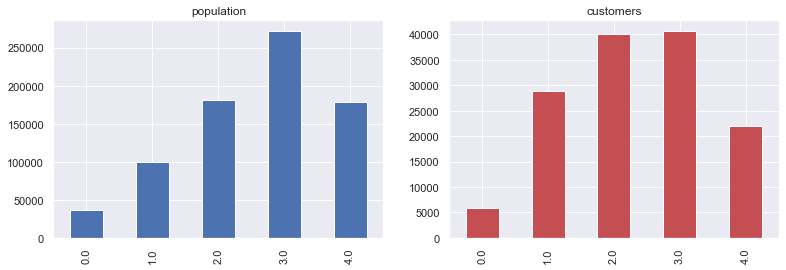

In [128]:
plot_feature_difference('KKK')

KKK	purchasing power	
-1, 0	unknown  
		1	very high  
		2	high  
		3	average  
		4	low

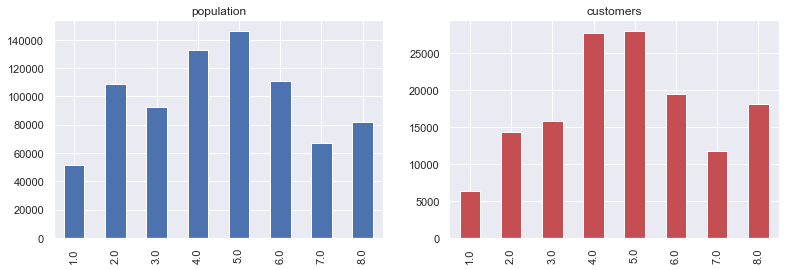

In [129]:
plot_feature_difference('INNENSTADT')

INNENSTADT	distance to the city centre	
-1	unknown  
		1	city centre  
		2	distance to the city centre 3 km  
		3	distance to the city centre 3-5 km  
		4	distance to the city centre 5-10 km  
		5	distance to the city centre 10-20 km  
		6	distance to the city centre 20-30 km  
		7	distance to the city centre 30-40 km  
		8	distance to the city centre > 40 km

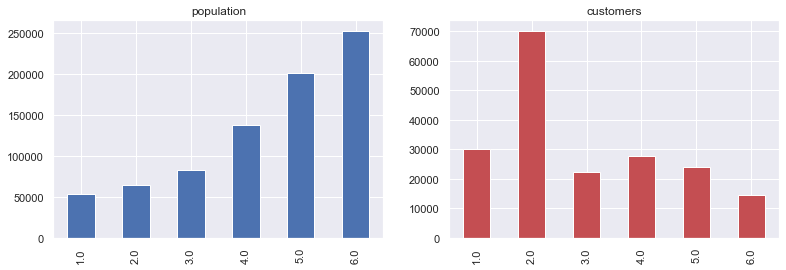

In [130]:
plot_feature_difference('HH_EINKOMMEN_SCORE')

HH_EINKOMMEN_SCORE	estimated household net income 	
-1, 0	unknown  
		1	highest income  
		2	very high income  
		3	high income   
		4	average income  
		5	lower income  
		6	very low income

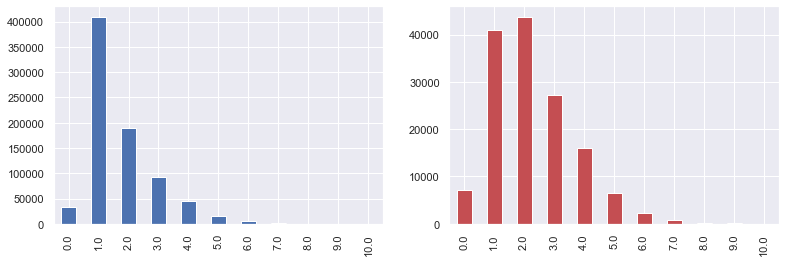

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,4))
dfa['ANZ_PERSONEN'].value_counts().sort_index()[:10].plot(kind = 'bar',ax=axes[0])
dfc['ANZ_PERSONEN'].value_counts().sort_index()[:10].plot(kind = 'bar',ax=axes[1],color='r')

ANZ_PERSONEN	number of adult persons in the household

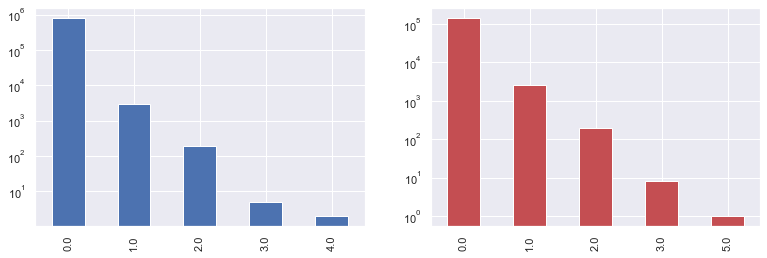

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,4))
dfa['ANZ_TITEL'].value_counts().sort_index()[:10].plot(kind = 'bar',ax=axes[0],logy=True)
dfc['ANZ_TITEL'].value_counts().sort_index()[:10].plot(kind = 'bar',ax=axes[1],logy=True,color='r');

ANZ_TITEL	number of professional title holder in household

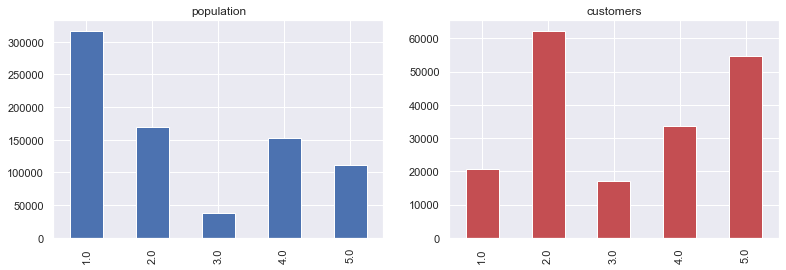

In [137]:
plot_feature_difference('LP_STATUS_GROB')

LP_STATUS_GROB	social status rough	
1	low-income earners  
		2average earners  
3independants  
4houseowners  
5top earners  

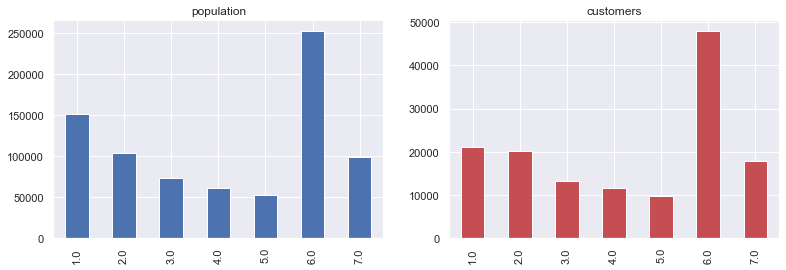

In [305]:
plot_feature_difference('BALLRAUM')

BALLRAUM	distance to next urban centre 
-1	unknown
		1	till 10 km    
		2	10 - 20 km   
		3	20 - 30 km  
		4	30 - 40 km  
		5	40 - 50 km  
		6	50-100 km  
		7	more than 100 km

### Summary
The customers are upper class high income earners, some medium and very few are low income. The customers are pretty old, very few less than 45 years old, with a large fraction over 60 and a peak of people 80 years old. Compared to the general population, few live in cities, few are single, many are two or more generational household, few are living in their home for less than 10 years, few are foreigners, few have a high mobility.

In [650]:
dfa.isna().sum().sort_values(ascending=False).head(10)

ALTER_KIND4                   790805
ALTER_KIND3                   785972
ALTER_KIND2                   763382
ALTER_KIND1                   713569
EXTSEL992                     561143
KK_KUNDENTYP                  495881
ALTERSKATEGORIE_FEIN          182523
D19_BANKEN_ONLINE_QUOTE_12    177989
D19_SOZIALES                  177989
D19_VERSI_ONLINE_QUOTE_12     177989
dtype: int64

In [180]:
many_nans = ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'KK_KUNDENTYP']

There are 6 columns which have more than 65% of null values, that we will remove.


In [75]:
values_per_feature = df.loc[:500000].nunique().value_counts().sort_index()

In [76]:
values_per_feature.to_frame().T

,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,22,26,32,35,36,41,43,45,46,56,115,246,271,1261,4579,500001
0,8,9,16,122,82,40,36,3,17,6,2,2,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


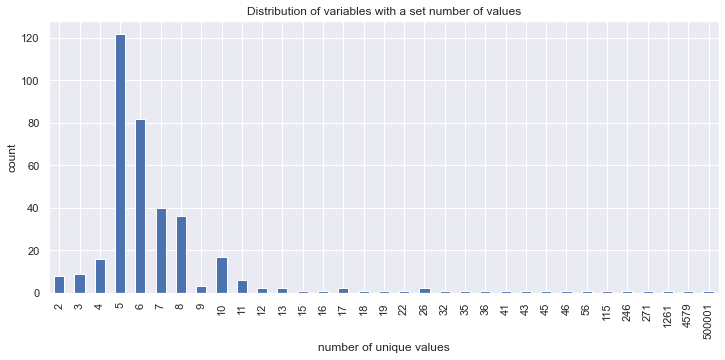

In [475]:
ax = values_per_feature.plot(kind='bar',figsize=(12,5),title='Distribution of variables with a set number of values')
ax.set_xlabel('number of unique values')
ax.set_ylabel('count');

By inspecting the distribution of variables with a set number of unique values, we observe that there are 8 binary variables, most of the variables have a pre-set number of values, being either categorical or ordinal. Inspecting the data dictionary it is possible to see that many of them are ordinal. While strictly not numerical, as the interval size can be meaningless, they can be used as numerical. We identify 22 categorical variables that we one-hot encode, after removing 9 of them that had large cardinality or do not seem relevant.

In [181]:
categorical = ['AGER_TYP','CAMEO_DEU_2015','CJT_GESAMTTYP','D19_KONSUMTYP','FINANZTYP','GEBAEUDETYP','KBA05_MAXVORB', 'LP_FAMILIE_FEIN','LP_FAMILIE_GROB',
               'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','RETOURTYP_BK_S','TITEL_KZ','ZABEOTYP', 'GFK_URLAUBERTYP',
               'KBA05_MAXHERST', 'KBA05_MODTEMP','D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ']

categorical_to_remove = ['AGER_TYP','CAMEO_DEU_2015','FINANZTYP','GEBAEUDETYP','KBA05_MAXVORB',
               'LP_LEBENSPHASE_FEIN','TITEL_KZ','KBA05_MODTEMP','D19_LETZTER_KAUF_BRANCHE']

In [557]:
print(len(categorical))
print(len(categorical_to_remove))

22
9


We remove the 99K rows with more than 150 null values.

In [182]:
(dfa.isnull().sum(axis=1)>150).sum()

99246

In [183]:
dfa = dfa[dfa.isnull().sum(axis=1)<150]

In [184]:
dfa.shape

(791972, 366)

In [185]:
def clean_segmentation(df, columns_to_drop, categorical):
    
    df = df.drop(columns_to_drop, axis=1)
    try: df = df.replace({'X': 0, 'XX': 0})
    except: pass
    if 'CAMEO_DEUG_2015' not in columns_to_drop:
        df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'], downcast='integer').fillna(0).astype('int')
        
    df = pd.get_dummies(df, columns = categorical)    
    df = df.fillna(df.mode().iloc[0])
    return df

We clean the data using the function defined above, dropping the columns we won't use, and we fill the null values with the mode of the column.

In [186]:
to_drop = many_nans + categorical_to_remove + ['LNR', 'EINGEFUEGT_AM']
dfa_cleaned = clean_segmentation(dfa, to_drop, categorical_to_save)

NameError: name 'categorical_to_save' is not defined

In [357]:
dfa_cleaned.shape

(791972, 417)

In [358]:
dfa_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,K

We rescale the data of each column by subtracting the mean and dividing by the standard deviation.

In [21]:
%%time
scaler=StandardScaler()
dfa_scaled = pd.DataFrame(scaler.fit_transform(dfa_cleaned.astype(float)))
dfa_scaled.columns = dfa_cleaned.columns
dfa_scaled.index = dfa_cleaned.index
dfa_scaled.head()

CPU times: user 16.9 s, sys: 1min 1s, total: 1min 17s
Wall time: 3min 5s


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,K

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dimensionality Reduction

We apply principal component analysis (PCA) to the data to reduce the dimensionality of the data.

In [478]:
pca = PCA(n_components=200)
pca_result = pca.fit_transform(dfa_scaled)

In [479]:
print(pca.explained_variance_ratio_[:12])
pca.explained_variance_ratio_.sum()

[0.07218098 0.06370314 0.04612881 0.03986324 0.03402885 0.02006106
 0.01777444 0.0148113  0.0133369  0.01253686 0.01138089 0.01066019]


0.9001662141335416

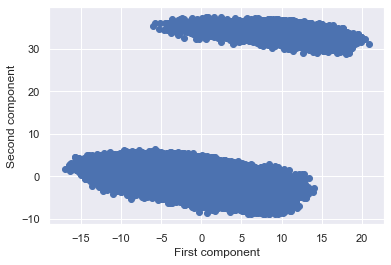

In [483]:
plt.scatter(pca_result[:,0],pca_result[:,1],figsize())
plt.xlabel('First component')
plt.ylabel('Second component');

The first component accounts for 7.2% of the variance while the second component for 6.4%. As it is possible to see from the plot above, it is possible to identify two big clusters by plotting the first two components, where the separation is mostly due to the second component.

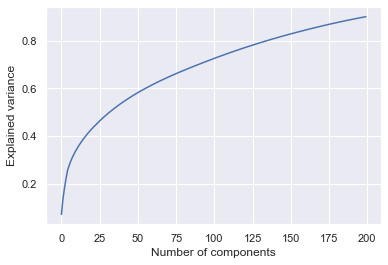

In [486]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance');

In [543]:
pca.explained_variance_ratio_[:140].sum()

0.8086134618982067

We considered up to 200 components that explain up to 90% of the variance. We select 140 components which explain 80% of the variance.

In [30]:
pca = PCA(n_components=140)
pca_result = pca.fit_transform(dfa_scaled)

In [545]:
v = pca.components_

In [546]:
features_list = dfa_scaled.columns

In [552]:
component_num = 0
comps = pd.DataFrame(list(zip(v[component_num,:], features_list)), 
                     columns=['weights', 'features'])

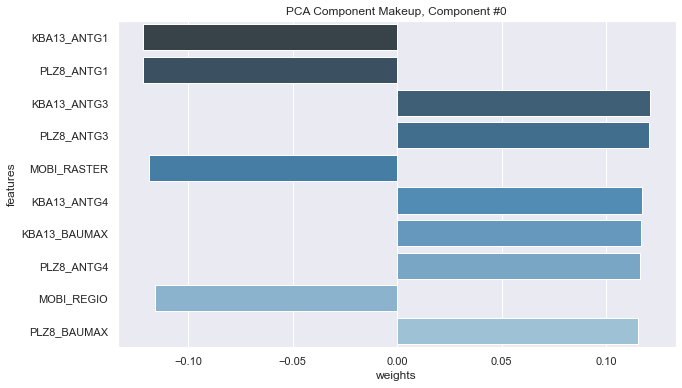

In [551]:
n_weights = 10
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

# display using seaborn
ax=plt.subplots(figsize=(10,6))
ax=sns.barplot(data=sorted_weight_data, 
               x="weights", 
               y="features", 
               palette="Blues_d")
ax.set_title("PCA Component Makeup, Component #" + str(component_num))
plt.show()

In [39]:
comps.sort_values('abs_weights', ascending=False).head(20)

,weights,features,abs_weights
170,-0.121519,KBA13_ANTG1,0.121519
292,-0.121419,PLZ8_ANTG1,0.121419
172,0.121203,KBA13_ANTG3,0.121203
294,0.120639,PLZ8_ANTG3,0.120639
288,-0.118727,MOBI_RASTER,0.118727
173,0.117356,KBA13_ANTG4,0.117356
177,0.116937,KBA13_BAUMAX,0.116937
295,0.116486,PLZ8_ANTG4,0.116486
289,-0.115874,MOBI_REGIO,0.115874
296,0.115422,PLZ8_BAUMAX,0.115422


KBA13_ANTG1 - no info  
PLZ8_ANTG1 - number of 1-2 family houses in the PLZ8  
KBA13_ANTG3 - no info  
PLZ8_ANTG3	- number of 6-10 family houses in the PLZ8  
MOBI_RASTER - no info  

The first component is related to the number of multi-family houses in the area and to the mobility of the person.

In [554]:
component_num = 1
comps = pd.DataFrame(list(zip(v[component_num,:], features_list)), 
                     columns=['weights', 'features'])

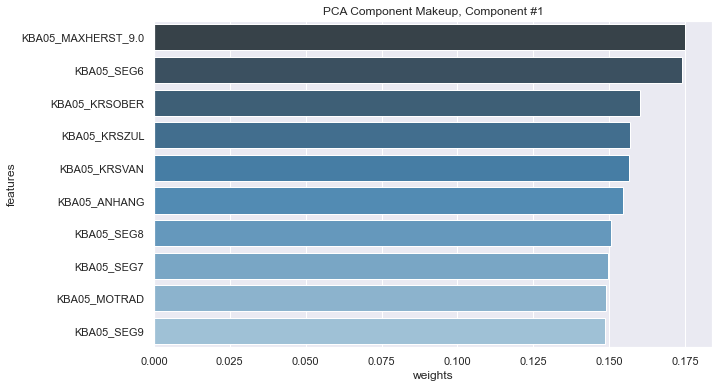

In [555]:
n_weights = 10
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

# display using seaborn
ax=plt.subplots(figsize=(10,6))
ax=sns.barplot(data=sorted_weight_data, 
               x="weights", 
               y="features", 
               palette="Blues_d")
ax.set_title("PCA Component Makeup, Component #" + str(component_num))
plt.show()

In [42]:
comps.sort_values('weights', ascending=False).head(20)

,weights,features,abs_weights
415,0.175039,KBA05_MAXHERST_9.0,0.175039
155,0.174076,KBA05_SEG6,0.174076
133,0.160026,KBA05_KRSOBER,0.160026
135,0.156918,KBA05_KRSZUL,0.156918
134,0.156364,KBA05_KRSVAN,0.156364
108,0.154442,KBA05_ANHANG,0.154442
157,0.150432,KBA05_SEG8,0.150432
156,0.149540,KBA05_SEG7,0.149540
148,0.148918,KBA05_MOTRAD,0.148918
158,0.148462,KBA05_SEG9,0.148462


KBA05_MAXHERST_9.0 - no info  
KBA05_SEG6 - share of upper class cars (BMW 7er etc.) in the microcell  
KBA05_KRSOBER - share of upper class cars (referred to the county average)  
KBA05_KRSZUL - share of newbuilt cars (referred to the county average)  
KBA05_KRSVAN -  share of vans (referred to the county average)  

The second component is related to car ownership in the area of living.

### Clustering

We perform the clustering using the k-means algorithm. To decide the number of clusters, we create up to 30 clusters using a mini-batch k-means as it is substantially faster. 

In [570]:
%%time
SSD = []
for i in range(2,30,2):
    kmeans = MiniBatchKMeans(n_clusters = i)
    kmeans.fit(pca_result)
    SSD.append(kmeans.inertia_)

CPU times: user 4min 5s, sys: 1min, total: 5min 6s
Wall time: 2min 17s


We plot the sum of squared distances of samples to their closest cluster center as a function of the number of clusters. 

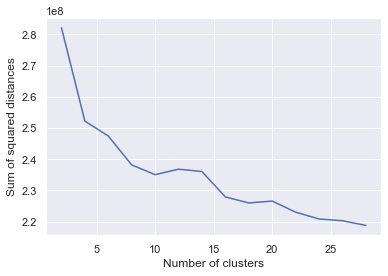

In [574]:
plt.plot(list(range(2,30,2)),SSD)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances');

Using the elbow method we pick 15 clusters.

In [45]:
n = 15
kmeans = KMeans(n_clusters=n, random_state=42)

In [46]:
model = kmeans.fit(pca_result)
clustered = model.predict(pca_result)

In [48]:
count = []
for i in range(n):
    count.append((clustered == i).sum())

In [50]:
count_df = pd.DataFrame(list(zip(range(15),count)), columns = ['Cluster', 'Population'])

We perform the same procedure of cleaning, scaling and decomposition in principal components to the customer data, and we divide the customers among the same clusters of the general population and compare the result.

In [56]:
to_drop_c = to_drop + ['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']
dfc_cleaned = clean_segmentation(dfc, to_drop_c, categorical_to_save)

In [57]:
dfc_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,K

In [58]:
dfc_scaled = pd.DataFrame(scaler.transform(dfc_cleaned.astype(float)))
dfc_scaled.columns = dfc_cleaned.columns
dfc_scaled.index = dfc_cleaned.index
dfc_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,K

In [59]:
pca_result_c = pca.transform(dfc_scaled)

In [61]:
model = kmeans.fit(pca_result_c)
clustered_c = model.predict(pca_result_c)

In [63]:
count_c = []
for i in range(n):
    count_c.append((clustered_c == i).sum())

In [64]:
count_df['Customers'] = count_c

In [82]:
count_df['Population_ratio'] = count_df['Population'] / count_df['Population'].sum()
count_df['Customers_ratio'] = count_df['Customers'] / count_df['Customers'].sum()
count_df['Ratio'] = count_df['Customers_ratio']  / count_df['Population_ratio']

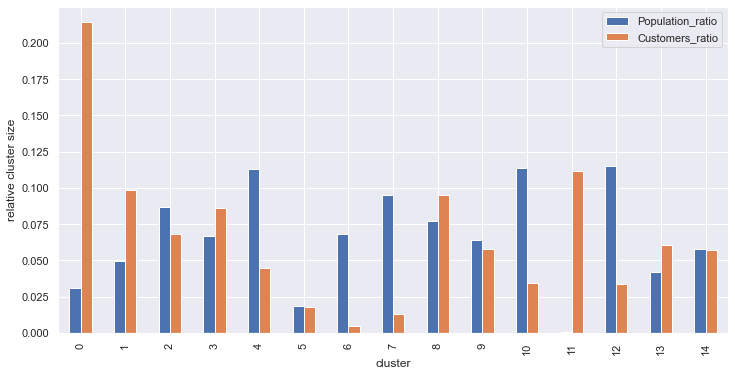

In [568]:
ax = count_df[['Population_ratio','Customers_ratio']].plot(kind='bar',figsize=(12,6))
ax.set_xlabel('cluster')
ax.set_ylabel('relative cluster size');

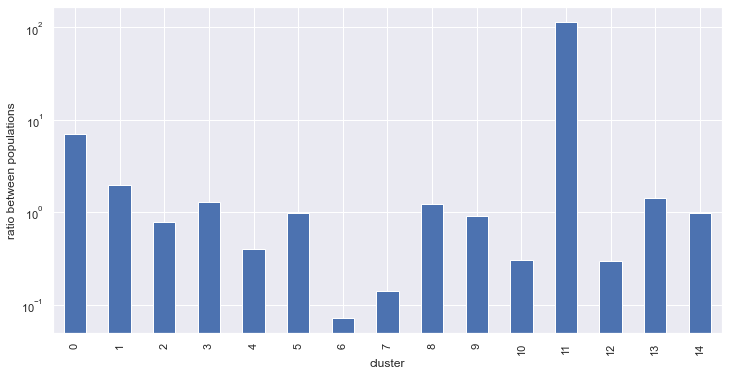

In [565]:
ax = count_df['Ratio'].plot(kind='bar',figsize=(12,6),logy=True)
ax.set_xlabel('cluster')
ax.set_ylabel('ratio between populations');

It is possible to see that the relative size of the clusters is substantially different between the general population and the customers. In particular we consider two clusters which are overrepresented by customers (cluster 0 and 11) and two underrepresented (cluster 6 and 7). Note that cluster 11 is in the general population is very small, but it is highly represented by customers.

In [146]:
cluster0 = pd.Series(kmeans.cluster_centers_[0])
cluster11 = pd.Series(kmeans.cluster_centers_[11])
cluster6 = pd.Series(kmeans.cluster_centers_[6])
cluster7 = pd.Series(kmeans.cluster_centers_[7])

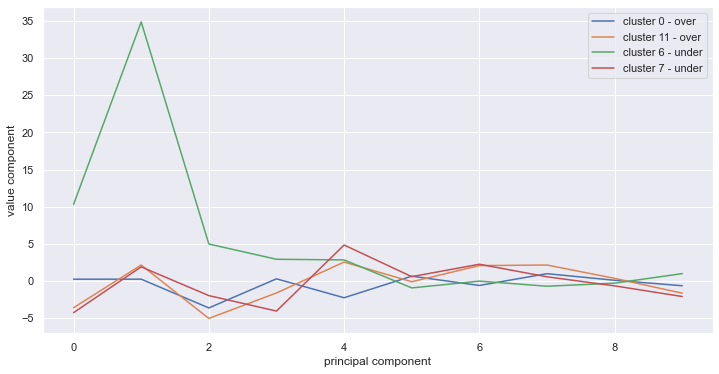

In [583]:
cluster0[:10].plot(label='cluster 0 - over',legend=True, figsize=(12,6))
cluster11[:10].plot(label='cluster 11 - over',legend=True)
cluster6[:10].plot(label='cluster 6 - under',legend=True)
ax = cluster7[:10].plot(label='cluster 7 - under',legend=True)
ax.set_xlabel('principal component')
ax.set_ylabel('value component');

From the plots of the different components it is not possible to understand clear patterns that distinguish the overrepresented by the underrepresented clusters. In fact the first two components of cluster 11 and 7 are almost identical even if they are part of the two different groups.

In [608]:
def plot_features_clusters(feature):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (13,8))
    dfa[clustered == 0][feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0,0],title='cluster 0 - over',color='C0')
    dfa[clustered == 11][feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0,1],title='cluster 11 - over',color='C1')
    dfa[clustered == 6][feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1,0],title='cluster 6 - under',color='C2')
    dfa[clustered == 7][feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1,1],title='cluster 7 - under',color='r')

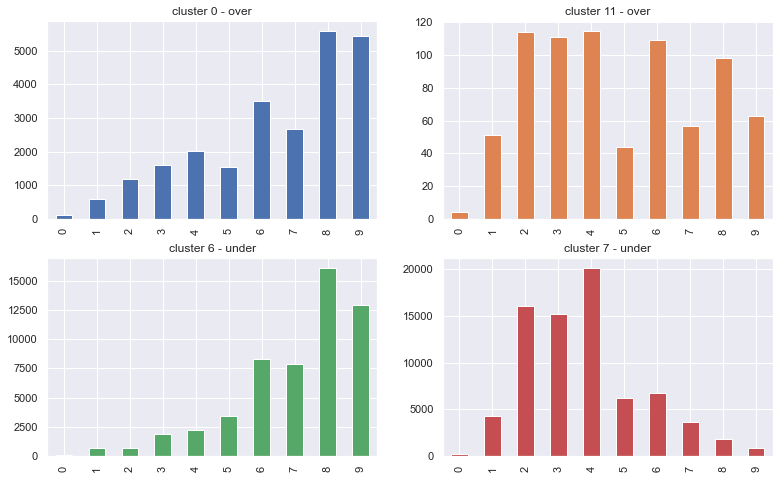

In [609]:
plot_features_clusters('CAMEO_DEUG_2015')

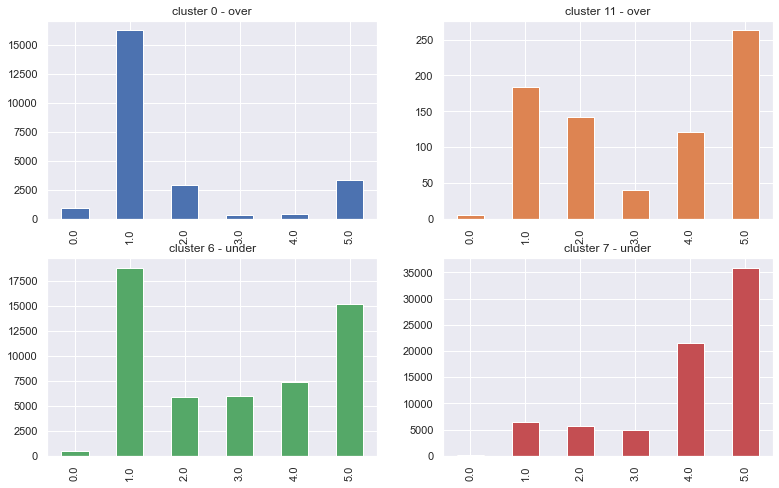

In [610]:
plot_features_clusters('LP_FAMILIE_GROB')

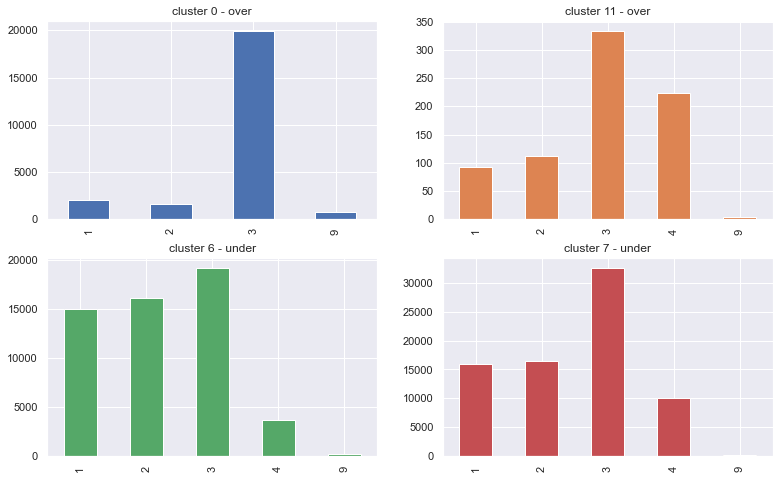

In [611]:
plot_features_clusters('ALTERSKATEGORIE_GROB')

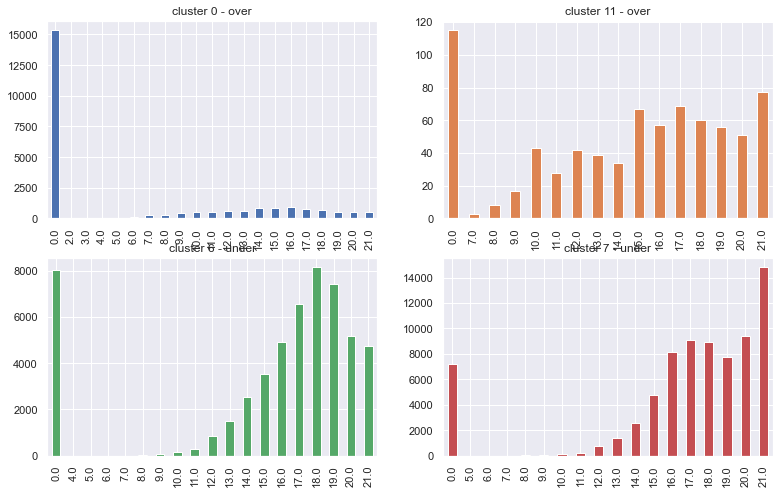

In [612]:
plot_features_clusters('ALTER_HH')

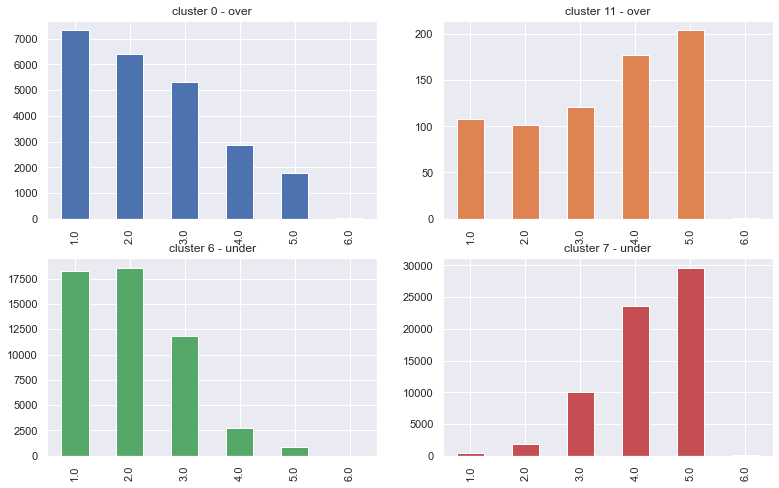

In [613]:
plot_features_clusters('MOBI_REGIO')

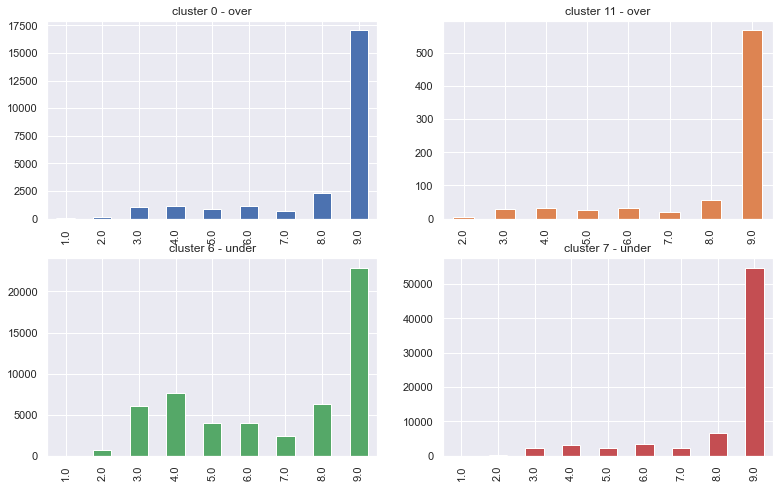

In [614]:
plot_features_clusters('WOHNDAUER_2008')

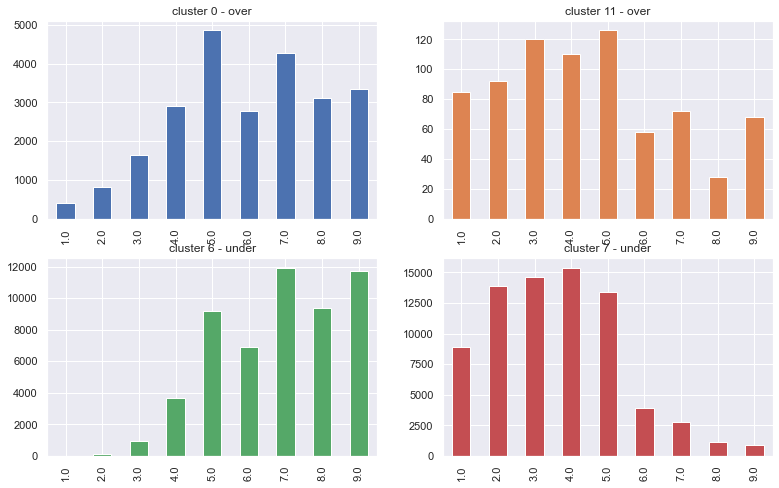

In [615]:
plot_features_clusters('ORTSGR_KLS9')

We hence investigated several characteristics for each of the 4 clusters, and again it is not easy to spot patterns between, aside for the older age of the overrepresented. It is surprising that the largest cluster overrepresented by customers (cluster 0) have a large percentage of working class and a large percentage of single people, in contrast with the general trend of the customers. This suggests that there is a specific cluster of customers even with these characteristics that differs from the general characteristics of the customers. However we suggest a further investigation of this cluster.

In [147]:
cluster0_scaled = pca.inverse_transform(cluster0)
cluster11_scaled = pca.inverse_transform(cluster11)
cluster6_scaled = pca.inverse_transform(cluster6)
cluster7_scaled = pca.inverse_transform(cluster7)

In [148]:
features_cluster_0 = scaler.inverse_transform(cluster0_scaled)
features_cluster_11 = scaler.inverse_transform(cluster11_scaled)
features_cluster_6 = scaler.inverse_transform(cluster6_scaled)
features_cluster_7 = scaler.inverse_transform(cluster7_scaled)

In [142]:
df_cluster = pd.DataFrame(columns=dfa_scaled.columns)

In [149]:
df_cluster.loc[0] = features_cluster_0 
df_cluster.loc[1] = features_cluster_11 
df_cluster.loc[2] = features_cluster_6 
df_cluster.loc[3] = features_cluster_7 

Below the value for each feature of each cluster center calculated using the inverse transforms. 

In [150]:
df_cluster

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,K

Below the list of features and the values of each cluster, which have a high variability among the 4 cluster considered.

In [187]:
df_cluster[df_cluster.std()[df_cluster.std()/dfa_cleaned[:1000].max()>0.4].index]

,ANZ_TITEL,D19_TELKO_ONLINE_QUOTE_12,GREEN_AVANTGARDE,HEALTH_TYP,KBA05_ALTER1,KBA05_ANHANG,KBA05_CCM4,KBA05_MOD1,KBA05_MOD8,KBA05_SEG1,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,SHOPPER_TYP,VERS_TYP,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_GROB_0.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_5.0,CJT_GESAMTTYP_6.0,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,GFK_URLAUBERTYP_5.0,KBA05_MAXHERST_9.0
0,-0.006383,-0.025929,0.241283,-1.589968,1.099460,1.386583,1.256443,1.212728,1.062748,1.103038,1.402023,0.073094,0.799528,0.647118,0.855208,-1.648611,-1.283750,0.964376,0.964376,0.826213,0.006011,-0.127305,0.966637,-0.018060,-0.127305,0.992671,0.975054,-0.037236,0.920183,-0.010100
1,-0.004241,0.001245,0.969364,1.836335,1.296267,1.267568,1.546525,1.777963,1.477582,1.128432,1.890018,0.191570,0.969032,0.998835,1.249143,1.475834,1.438301,0.054719,0.054719,-0.020196,0.005915,0.945609,0.004649,0.011745,0.945609,0.036878,0.019099,0.972701,0.125344,-0.000377
2,0.008403,-0.001334,0.077740,1.691285,8.949601,8.567758,9.066437,9.008835,9.029804,9.086190,8.973623,8.946743,8.991438,9.123271,9.012991,1.633093,1.563608,0.191181,0.191181,-0.008625,0.024282,0.019864,0.262590,0.039249,0.019864,0.091118,0.035650,0.943336,0.030870,0.989646
3,0.822393,0.020822,0.841337,1.893971,1.311092,0.918696,1.940006,1.998697,1.336849,1.045893,2.076164,0.260431,0.978576,1.145345,1.111317,1.362228,1.538095,0.003293,0.003293,-0.009048,1.304513,0.040773,-0.064948,1.135931,0.040773,0.087298,0.031505,0.958789,0.122167,0.000957


### Clustering on a subset of features

We recalculate the clustering on a subset of features that we think best represent the customers.

In [ ]:
subset = ['WOHNDAUER_2008', 'REGIOTYP', 'PLZ8_HHZ', 'ORTSGR_KLS9','NATIONALITAET_KZ',  'KKK', 'INNENSTADT', 'HH_EINKOMMEN_SCORE', 'D19_VERSAND_ONLINE_QUOTE_12', 
'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_24', 'CAMEO_DEUG_2015', 'BALLRAUM', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'ANREDE_KZ', 'ALTER_HH', 'ALTERSKATEGORIE_GROB',
'MOBI_REGIO', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN']

In [197]:
to_drop = set(dfa.columns)-set(subset)
print(len(to_drop))
categorical_selected = set(categorical_to_save).intersection(subset)
print(len(categorical_selected))

345
4


In [211]:
dfa_cleaned_sel = clean_segmentation(dfa, to_drop, categorical_selected)

In [212]:
dfa_cleaned_sel.head()

,ALTER_HH,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ANZ_24,D19_VERSAND_ONLINE_QUOTE_12,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,ORTSGR_KLS9,PLZ8_HHZ,REGIOTYP,WOHNDAUER_2008,ANREDE_KZ,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0
1,0.0,0.0,2.0,0.0,6.0,8,0.0,0,0.0,6.0,8.0,2.0,5.0,5.0,3.0,9.0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,17.0,0.0,1.0,0.0,2.0,4,0.0,0,0.0,4.0,4.0,2.0,5.0,4.0,2.0,9.0,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,13.0,0.0,0.0,0.0,4.0,2,0.0,0,0.0,1.0,6.0,0.0,3.0,3.0,0.0,9.0,2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,20.0,0.0,4.0,0.0,2.0,6,10.0,6,10.0,5.0,1.0,3.0,6.0,3.0,5.0,9.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
5,10.0,0.0,1.0,0.0,6.0,8,10.0,0,0.0,5.0,7.0,4.0,3.0,5.0,5.0,9.0,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [213]:
to_drop_c = list(to_drop) + ['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']
dfc_cleaned_sel = clean_segmentation(dfc, to_drop_c , categorical_selected) 

In [214]:
scaler_sel=StandardScaler()
dfa_scaled_sel = pd.DataFrame(scaler_sel.fit_transform(dfa_cleaned_sel.astype(float)))
dfa_scaled_sel.columns = dfa_cleaned_sel.columns
dfa_scaled_sel.index = dfa_cleaned_sel.index
dfa_scaled_sel.head()

,ALTER_HH,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ANZ_24,D19_VERSAND_ONLINE_QUOTE_12,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,ORTSGR_KLS9,PLZ8_HHZ,REGIOTYP,WOHNDAUER_2008,ANREDE_KZ,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0
1,-1.424351,-0.125316,0.233012,-0.060662,0.846076,0.988122,-0.631314,-0.664791,-0.589089,1.021148,1.702634,-0.549486,-0.128953,1.447891,-0.650052,0.560952,0.957744,1.224270,-0.522232,-0.223806,-0.487486,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,-1.009026,-0.374773,-0.076259,-0.121242,8.384368,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,-0.186066,-1.009026,-0.374773,5.306559,-0.257596,-0.556470
2,0.802351,-0.125316,-0.630529,-0.060662,-0.985286,-0.600408,-0.631314,-0.664791,-0.589089,-0.273892,-0.269303,-0.549486,-0.128953,0.414111,-1.144882,0.560952,0.957744,-0.816813,1.914859,-0.223806,-0.487486,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,0.991055,-0.374773,-0.076259,-0.121242,-0.119270,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,-0.186066,0.991055,-0.374773,-0.188446,-0.257596,-0.556470
3,0.278421,-0.125316,-1.494070,-0.060662,-0.069605,-1.394674,-0.631314,-0.664791,-0.589089,-2.216452,0.716665,-2.361844,-0.999575,-0.619668,-2.134543,0.560952,0.957744,-0.816813,-0.522232,-0.223806,2.051339,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,5.374447,-1.009026,-0.374773,-0.076259,-0.121242,-0.119270,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,5.374447,-1.009026,-0.374773,-0.188446,-0.257596,-0.556470
4,1.195299,-0.125316,1.960095,-0.060662,-0.985286,0.193857,1.663264,3.166948,1.761609,0.373628,-1.748255,0.356693,0.306359,-0.619668,0.339609,0.560952,-1.044120,-0.816813,1.914859,-0.223806,-0.487486,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,-1.009026,-0.374773,-0.076259,-0.121242,-0.119270,-0.102876,-0.158229,-0.167622,-0.115337,2.274502,-0.255606,-0.186066,-1.009026,-0.374773,-0.188446,-0.257596,1.797043
5,-0.114526,-0.125316,-0.630529,-0.060662,0.846076,0.988122,1.663264,-0.664791,-0.589089,0.373628,1.209650,1.262872,-0.999575,1.447891,0.339609,0.560952,0.957744,-0.816813,1.914859,-0.223806,-0.487486,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,0.991055,-0.374773,-0.076259,-0.121242,-0.119270,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,-0.186066,0.991055,-0.374773,-0.188446,-0.257596,-0.556470


In [215]:
dfc_scaled_sel = pd.DataFrame(scaler_sel.transform(dfc_cleaned_sel.astype(float)))
dfc_scaled_sel.columns = dfc_cleaned_sel.columns
dfc_scaled_sel.index = dfc_cleaned_sel.index
dfc_scaled_sel.head()

,ALTER_HH,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ANZ_24,D19_VERSAND_ONLINE_QUOTE_12,HH_EINKOMMEN_SCORE,INNENSTADT,KKK,ORTSGR_KLS9,PLZ8_HHZ,REGIOTYP,WOHNDAUER_2008,ANREDE_KZ,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0
0,-0.114526,-0.125316,0.233012,-0.060662,-0.527446,-1.791806,-0.631314,-0.664791,-0.589089,-2.216452,-0.269303,-1.455665,-1.434887,1.447891,-1.639712,0.560952,-1.044120,-0.816813,-0.522232,-0.223806,-0.487486,2.479602,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,-1.009026,2.668282,-0.076259,-0.121242,-0.11927,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,-0.186066,-1.009026,2.668282,-0.188446,-0.257596,-0.556470
1,0.016456,-0.125316,1.096554,-0.060662,0.846076,-2.188939,-0.631314,-0.664791,-0.589089,-1.568932,0.223681,0.356693,-0.128953,-0.619668,0.834439,0.560952,-1.044120,-0.816813,-0.522232,-0.223806,-0.487486,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,-1.009026,-0.374773,-0.076259,-0.121242,-0.11927,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,-0.186066,-1.009026,-0.374773,-0.188446,-0.257596,-0.556470
2,-0.638456,-0.125316,-0.630529,-0.060662,1.303917,-0.203276,-0.631314,-0.664791,-0.589089,-2.216452,-1.748255,0.356693,-0.128953,-0.619668,1.329270,0.560952,0.957744,-0.816813,-0.522232,-0.223806,-0.487486,2.479602,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,0.991055,-0.374773,-0.076259,-0.121242,-0.11927,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,-0.186066,0.991055,-0.374773,-0.188446,-0.257596,-0.556470
3,-0.376491,-0.125316,-1.494070,-0.060662,1.303917,-0.600408,-0.631314,-0.026168,-0.589089,-0.273892,1.209650,0.356693,-0.999575,-0.619668,0.834439,0.560952,-1.044120,-0.816813,-0.522232,-0.223806,2.051339,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,5.374447,-1.009026,-0.374773,-0.076259,-0.121242,-0.11927,-0.102876,-0.158229,-0.167622,-0.115337,-0.439657,-0.255606,5.374447,-1.009026,-0.374773,-0.188446,-0.257596,-0.556470
4,1.195299,-0.125316,1.960095,-0.060662,-0.527446,0.590989,1.663264,2.528324,1.761609,1.021148,-0.269303,1.262872,-0.128953,-0.619668,1.329270,0.560952,-1.044120,1.224270,-0.522232,-0.223806,-0.487486,-0.403291,-0.210783,0.441555,-0.294591,-0.206153,-0.186066,-1.009026,-0.374773,-0.076259,-0.121242,-0.11927,-0.102876,-0.158229,-0.167622,-0.115337,2.274502,-0.255606,-0.186066,-1.009026,-0.374773,-0.188446,-0.257596,1.797043


In [217]:
pca_sel = PCA(n_components=30)
pca_result_sel = pca_sel.fit_transform(dfa_scaled_sel)

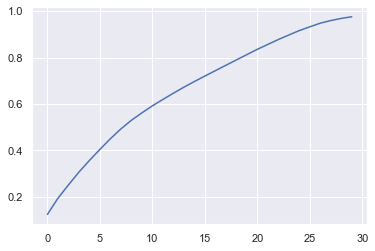

In [219]:
plt.plot(np.cumsum(pca_sel.explained_variance_ratio_));

In [228]:
pca_sel = PCA(n_components=17)
pca_result_sel = pca_sel.fit_transform(dfa_scaled_sel)
print(pca_sel.explained_variance_ratio_)
print('Total variance explained:', pca_sel.explained_variance_ratio_.sum())

[0.12349837 0.06952024 0.05753045 0.05524963 0.05029388 0.04770616
 0.04607269 0.04221881 0.03734201 0.03186578 0.03032364 0.02762142
 0.02682416 0.02599021 0.02432801 0.02352443 0.02325856]
Total variance explained: 0.7431684523467649


In [229]:
features_list = dfa_scaled_sel.columns

In [230]:
SSD_sel = []
for i in range(2,30,2):
    kmeans_sel = MiniBatchKMeans(n_clusters = i)
    kmeans_sel.fit(pca_result_sel)
    SSD_sel.append(kmeans_sel.inertia_)

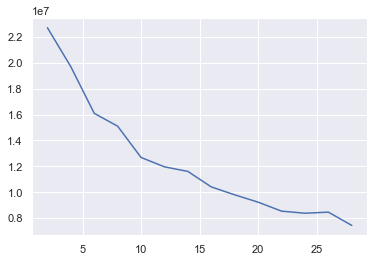

In [231]:
plt.plot(list(range(2,30,2)),SSD_sel);

In [232]:
n = 10
kmeans_sel = KMeans(n_clusters=n, random_state=42)

In [233]:
model_sel = kmeans_sel.fit(pca_result_sel)

In [234]:
clustered_sel = model_sel.predict(pca_result_sel)

In [235]:
pca_result_sel_c = pca_sel.transform(dfc_scaled_sel)

In [237]:
clustered_sel_c = model_sel.predict(pca_result_sel_c)

In [238]:
count_sel = []
for i in range(n):
    count_sel.append((clustered_sel == i).sum())

In [239]:
count_sel_c = []
for i in range(n):
    count_sel_c.append((clustered_sel_c == i).sum())

In [240]:
count_sel_df = pd.DataFrame(list(zip(range(15),count_sel)), columns = ['Cluster', 'Population'])
count_sel_df['Customers'] = count_sel_c

In [241]:
count_sel_df

,Cluster,Population,Customers
0,0,3509,2969
1,1,196802,30554
2,2,57863,24288
3,3,128638,36447
4,4,205382,11762
5,5,97016,28333
6,6,27593,3754
7,7,21572,4615
8,8,27130,1589
9,9,26469,47341


In [242]:
count_sel_df['Population_ratio'] = count_sel_df['Population'] / count_sel_df['Population'].sum()
count_sel_df['Customers_ratio'] = count_sel_df['Customers'] / count_sel_df['Customers'].sum()
count_sel_df['Ratio'] = count_sel_df['Customers_ratio']  / count_sel_df['Population_ratio']

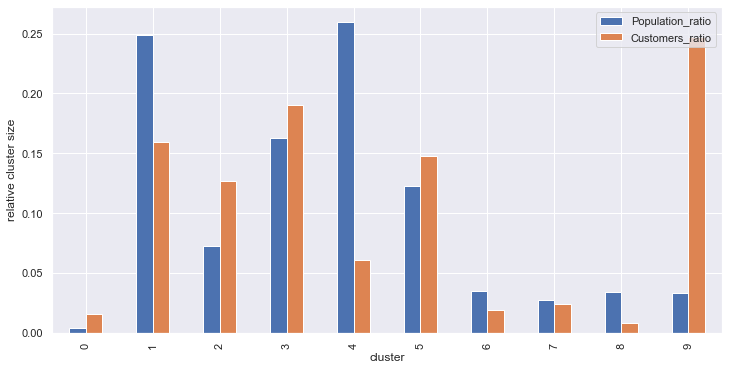

In [645]:
ax = count_sel_df[['Population_ratio','Customers_ratio']].plot(kind='bar',figsize=(12,6))
ax.set_xlabel('cluster')
ax.set_ylabel('relative cluster size');

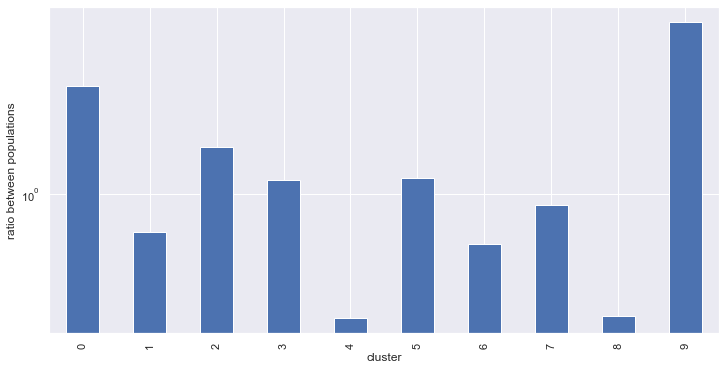

In [646]:
ax = count_sel_df['Ratio'].plot(kind='bar',figsize=(12,6),logy=True)
ax.set_xlabel('cluster')
ax.set_ylabel('ratio between populations');

We identify cluster 9 as the most represented by customers and cluster 4 least represented by customers.

In [246]:
cluster_sel9 = pd.Series(kmeans_sel.cluster_centers_[9])
cluster_sel4 = pd.Series(kmeans_sel.cluster_centers_[4])

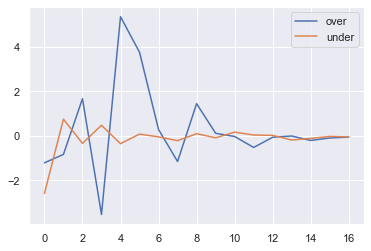

In [247]:
cluster_sel9.plot(label='over',legend=True)
cluster_sel4.plot(label='under',legend=True)

In [641]:
def plot_features_clusters_sel(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,4))
    dfa[clustered_sel == 9][feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='over')
    dfa[clustered_sel == 4][feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='under',color='r')

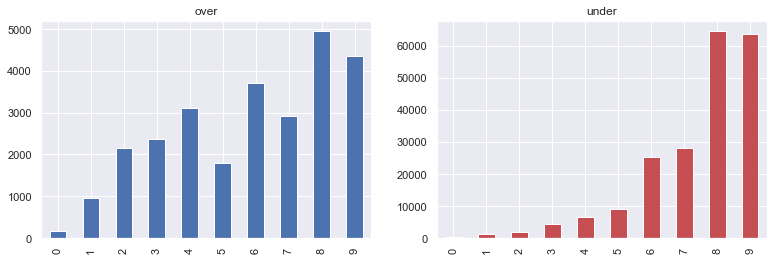

In [260]:
plot_features_clusters_sel('CAMEO_DEUG_2015')

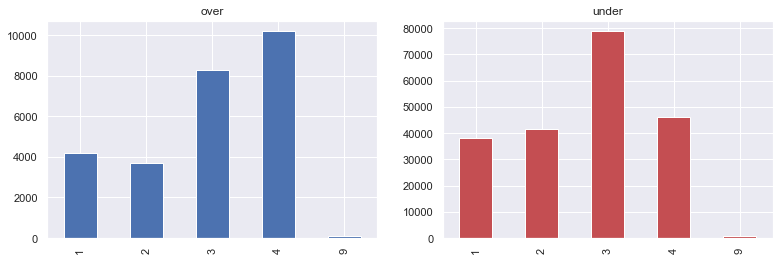

In [262]:
plot_features_clusters_sel('ALTERSKATEGORIE_GROB')

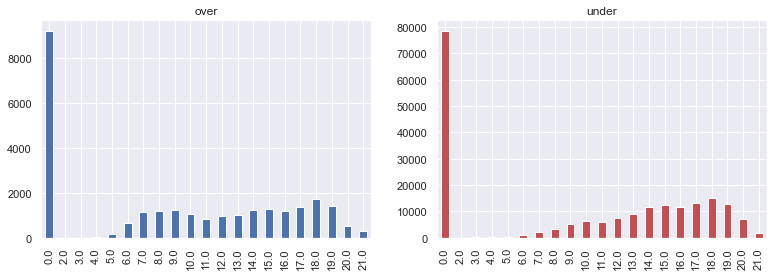

In [263]:
plot_features_clusters_sel('ALTER_HH')

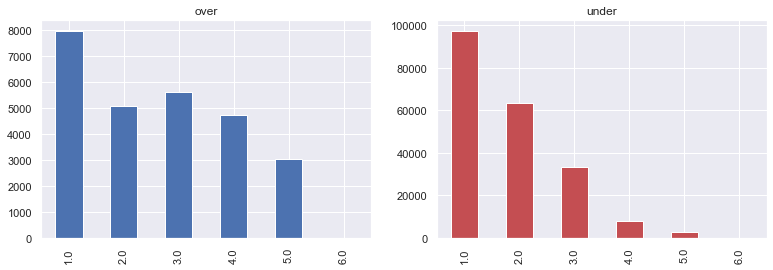

In [264]:
plot_features_clusters_sel('MOBI_REGIO')

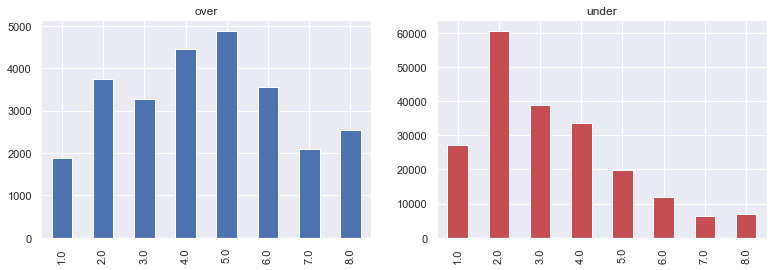

In [269]:
plot_features_clusters_sel('INNENSTADT')

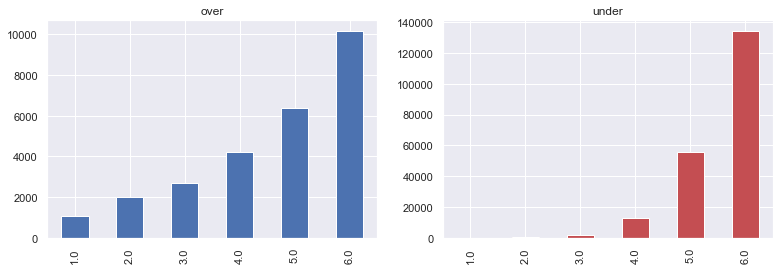

In [270]:
plot_features_clusters_sel('HH_EINKOMMEN_SCORE')

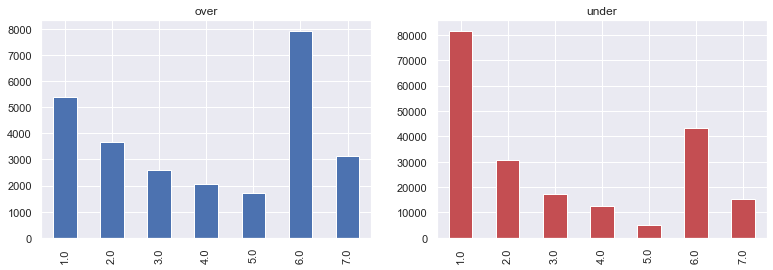

In [274]:
plot_features_clusters_sel('BALLRAUM')

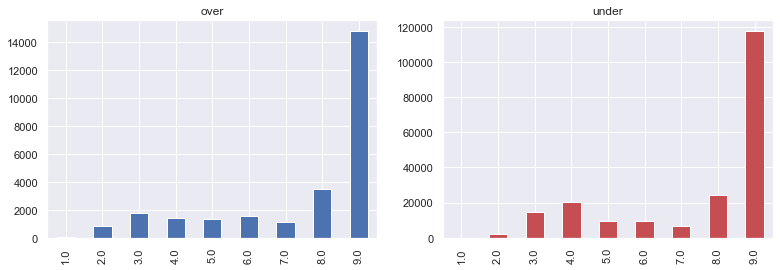

In [281]:
plot_features_clusters_sel('WOHNDAUER_2008')

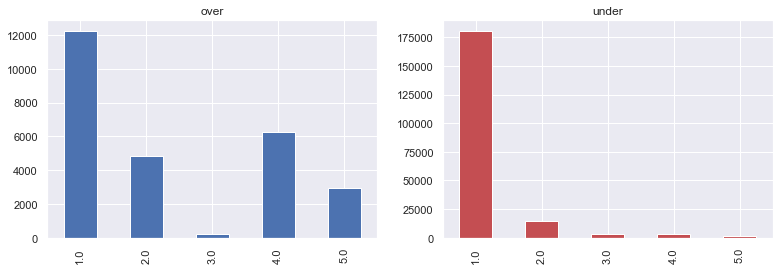

In [295]:
plot_features_clusters_sel('LP_STATUS_GROB')

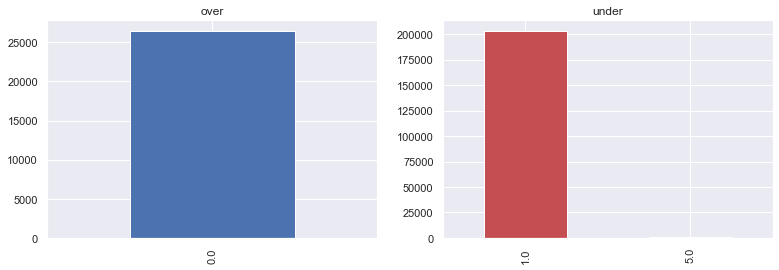

In [288]:
plot_features_clusters_sel('LP_FAMILIE_GROB')

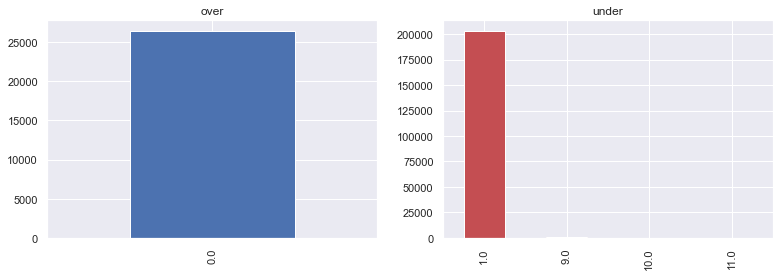

In [289]:
plot_features_clusters_sel('LP_FAMILIE_FEIN')

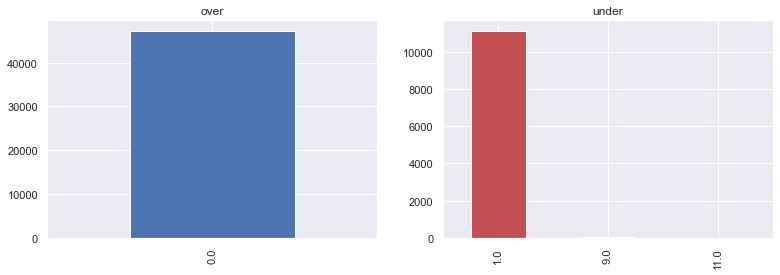

In [304]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,4))
dfc[clustered_sel_c == 9]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',title='over',ax=axes[0])
dfc[clustered_sel_c == 4]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',title='under',ax=axes[1],color='r')

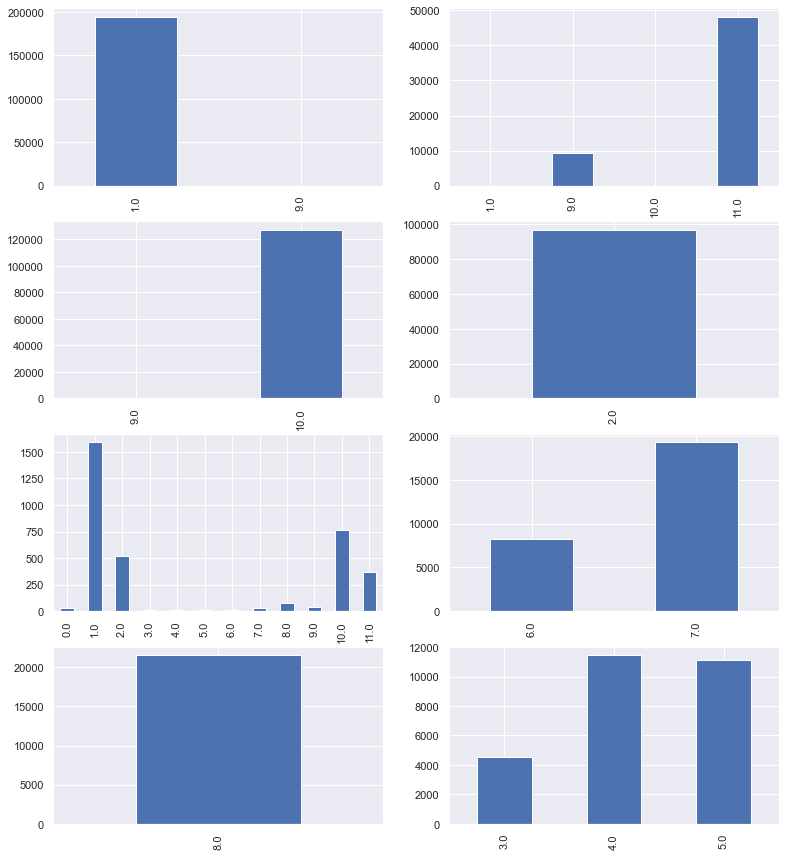

In [299]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize = (13,15))
dfa[clustered_sel == 1]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[0,0])
dfa[clustered_sel == 2]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[0,1])
dfa[clustered_sel == 3]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[1,0])
dfa[clustered_sel == 5]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[1,1])
dfa[clustered_sel == 0]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[2,0])
dfa[clustered_sel == 6]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[2,1])
dfa[clustered_sel == 7]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[3,0])
dfa[clustered_sel == 8]['LP_FAMILIE_FEIN'].value_counts().sort_index().plot(kind = 'bar',ax=axes[3,1])

Comparing the overrepresented cluster against the underrepresented cluster we see how the cluster overrepresented by customers have higher income, are older, have lower mobility, and live further from the city center. Other attributes are similar. This is consistent with the exploratory analysis comparing the general population to the customers.

It is interesting how the clusters, aside for cluster 0 which is a very small cluster, clustered the family attributes (LP_FAMILIE_FEIN) in almost pure sections. The cluster number 9, the one which is overrepresented by the customers is represented only by the people with family attribute unknown. It follows that this cluster should be interpreted with care, as its most characterizing feature is an artificial one. It is worth investigating the reason why the customers have a much larger percentage of unknown family attribute. However, the analysis could be repeated getting rid of cutomers with these unknown family attributes. and see if the conclusions hold.